In [1]:
import json
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import torch
import torch.nn as nn
from PIL import Image
from tqdm import tqdm
from transformers import AdamW, ViTModel, BertModel, BertTokenizer, ViTFeatureExtractor
from torch.nn.functional import cosine_similarity

/home/ayu/Downloads/archive/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

# Load Vision Transformer (ViT) model and feature extractor
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')
vit_model = ViTModel.from_pretrained('google/vit-base-patch16-224')

/home/ayu/Downloads/archive/.venv/lib/python3.12/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
# Custom model for BERT embeddings (Text Embeddings)
class BertForImageRetrieval(nn.Module):
    def __init__(self, bert_model):
        super(BertForImageRetrieval, self).__init__()
        self.bert = bert_model
        self.fc = nn.Linear(768, 512)  # Map to 512-dim embedding

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs[1]  # Pooled [CLS] token output
        return self.fc(pooled_output)

# Custom model for ViT embeddings (Image Embeddings)
class ViTForImageRetrieval(nn.Module):
    def __init__(self, vit_model):
        super(ViTForImageRetrieval, self).__init__()
        self.vit = vit_model
        self.fc = nn.Linear(768, 512)  # Map to 512-dim embedding

    def forward(self, pixel_values):
        outputs = self.vit(pixel_values=pixel_values)
        return self.fc(outputs.pooler_output)

# Initialize the custom BERT and ViT models
bert_retrieval_model = BertForImageRetrieval(bert_model)
vit_retrieval_model = ViTForImageRetrieval(vit_model)

In [3]:
def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image = image.resize((224, 224))
    # resizes the image to 224x224
    image = feature_extractor(images=image, return_tensors="pt")
    return image['pixel_values']

# Extract image embeddings using the fine-tuned ViT model
def get_image_embedding(image_path):
    image = preprocess_image(image_path)
    with torch.no_grad():
        outputs = vit_retrieval_model(image)
    return outputs

# Extract text embeddings using the fine-tuned BERT model
def get_text_embedding(caption):
    inputs = tokenizer(caption, return_tensors='pt', truncation=True, padding=True)
    with torch.no_grad():
        text_embedding = bert_retrieval_model(inputs.input_ids, inputs.attention_mask)
    return text_embedding

In [4]:
def cross_entropy_loss(comb_emb, image_embeddings, label):
    # Compute cosine similarity (between -1 and 1)
    similarities = cosine_similarity(comb_emb, image_embeddings)
    logits = similarities.unsqueeze(0)  # Add batch dimension
    logits = torch.cat([1 - logits, logits], dim=1)  # Two classes: non-match (0) and match (1)

    # Create target label
    labels = torch.tensor([label], dtype=torch.long)

    # Define loss function
    loss_fn = nn.CrossEntropyLoss()
    return loss_fn(logits, labels)

In [7]:
optimizer = torch.optim.AdamW(
    list(bert_retrieval_model.parameters()) + list(vit_retrieval_model.parameters()), lr=1e-5
)

In [ ]:
# Function to randomly select a non-matching target image
def get_random_image(image_dir, current_target_id):
    image_files = [f for f in os.listdir('fashionIQ_dataset/image_splits') if f.endswith('train.json')]
    image_set = []
    for file in image_files:
        with open(os.path.join('fashionIQ_dataset/image_splits', file), 'r') as f:
            image_set += json.load(f)

    if current_target_id in image_set:
        image_set.remove(current_target_id)
    random_item = random.choice(image_set)
    return os.path.join(image_dir, random_item + '.jpg')

In [ ]:
# Training loop
bert_retrieval_model.train()
vit_retrieval_model.train()

caption_dir = 'fashionIQ_dataset/captions'
image_dir = 'fashionIQ_dataset/images'

losses = []
for filename in [f for f in os.listdir(caption_dir) if f.endswith('.train.json')]:
    print(filename)
    caption_file = os.path.join(caption_dir, filename)
    with open(caption_file, 'r') as f:
        captions_data = json.load(f)

    for item in tqdm(captions_data):
        target_image_id = item['target']
        candidate_image_id = item['candidate']
        captions = item['captions'][0] +  " and " + item['captions'][1]

        # Paths for target and candidate images
        target_image_path = os.path.join(image_dir, target_image_id + ".jpg")
        candidate_image_path = os.path.join(image_dir, candidate_image_id + ".jpg")

        try:
            # Get image embeddings for target and candidate
            target_image_emb = get_image_embedding(target_image_path).requires_grad_()
            candidate_image_emb = get_image_embedding(candidate_image_path).requires_grad_()

            # Positive Pair (Matching candidate image and caption)
            text_emb = get_text_embedding(captions).requires_grad_()
            comb_emb = (text_emb.clone() + candidate_image_emb.clone())/2
            positive_loss = cross_entropy_loss(comb_emb, target_image_emb, label=1)    

            # get a negative taget image embedding
            negative_image_emb =  get_image_embedding(get_random_image(image_dir, target_image_id))
            negative_loss = cross_entropy_loss(comb_emb, negative_image_emb, label=0)

            # Total loss (sum of positive and negative losses)
            total_loss = positive_loss + negative_loss
            losses.append(total_loss.item())

            # Backpropagation
            total_loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        except Exception as e:
            print(f"Error processing image {candidate_image_id}: {e}")

cap.toptee.train.json


100%|██████████| 6027/6027 [33:31<00:00,  3.00it/s] 


cap.dress.train.json


100%|██████████| 5985/5985 [35:03<00:00,  2.84it/s]  


cap.shirt.train.json


100%|██████████| 5988/5988 [36:03<00:00,  2.77it/s]  


In [67]:
# save the model binaries
torch.save(bert_retrieval_model.state_dict(), 'bert_retrieval_model.pth')
torch.save(vit_retrieval_model.state_dict(), 'vit_retrieval_model.pth')

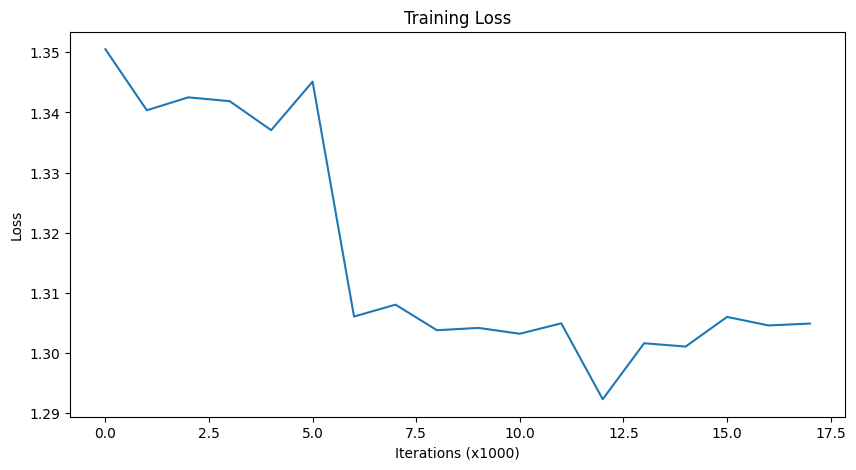

In [73]:
# learning curve using losses
loss_sample = [np.mean(losses[i:i+1000]) for i in range(0, len(losses), 1000)]
plt.figure(figsize=(10, 5))
plt.plot(loss_sample)
plt.xlabel('Iterations (x1000)')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [10]:
if os.path.exists('image_embeddings.pth'):
    map_image_emb = torch.load('image_embeddings.pth')
else:
    image_files = os.listdir(image_dir)
    map_image_emb = {}

    # dictionary of image and its embeddings
    for image in tqdm(image_files):
        map_image_emb[image.replace('.jpg', '')] = get_image_embedding(os.path.join(image_dir, image))

    # Save the image embeddings
    torch.save(map_image_emb, 'image_embeddings.pth')

print(f"Total images: {len(map_image_emb.keys())}")

/tmp/ipykernel_130485/3245621761.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  map_image_emb = torch.load('image_embeddings.pth')


Total images: 74381


In [ ]:
# Validation loop
bert_retrieval_model.eval()
vit_retrieval_model.eval()

caption_dir = 'fashionIQ_dataset/captions'
image_dir = 'fashionIQ_dataset/images'
image_splits_dir = 'fashionIQ_dataset/image_splits'

retrieved_images = []
target_images = []

# Function to compute Euclidean distance between two embeddings
def euclidean_distance(embedding1, embedding2):
    return torch.sqrt(torch.sum((embedding1 - embedding2) ** 2))

for filename in [f for f in os.listdir(caption_dir) if f.endswith('.val.json')]:
    print(filename)
    caption_file = os.path.join(caption_dir, filename)
    with open(caption_file, 'r') as f:
        captions_data = json.load(f)

    image_file = os.path.join(image_splits_dir, filename.replace('cap', 'split'))
    with open(image_file, 'r') as f:
        image_data = json.load(f)

    for item in tqdm(captions_data):
        candidate = item['candidate']
        caption = item['captions'][0] + " and " + item['captions'][1]

        query_image_emb = map_image_emb[candidate]
        query_text_emb = get_text_embedding(caption)
        combined_query_emb = (query_image_emb + query_text_emb) / 2.0 

        image_distances =[]
        for image in image_data:
            try:
                image_emb = map_image_emb[image]
                distance = euclidean_distance(combined_query_emb, image_emb)
                
                # Append tuple (image id, distance) to list
                image_distances.append((image, distance.item()))
            except Exception as e:
                print(f"Error processing image {image}: {e}")
        
        image_distances.sort(key=lambda x: x[1], reverse=False)
        retrieved_images.append(image_distances[:5])
        target_images.append(item['target'])

print(f"Total candidates: {len(retrieved_images)}")
print(f"Total targets: {len(target_images)}")

cap.toptee.val.json


100%|██████████| 1961/1961 [03:05<00:00, 10.59it/s]


cap.shirt.val.json


100%|██████████| 2038/2038 [03:33<00:00,  9.53it/s]


cap.dress.val.json


100%|██████████| 2017/2017 [02:50<00:00, 11.81it/s]

Total candidates: 6016
Total targets: 6016


In [ ]:
# # Function to calculate recall
# def calculate_recall(retrieved_images, target_images):    
#     ret_img = []
#     for relevant_arr in retrieved_images:
#         x = [img for img, _ in relevant_arr]
#         for i in x:
#             ret_img.append(i)
        
#     # make set from array to get unique images
#     # use set intersection (&) to get common images
#     # relevant_retrieved is the number of target images included in the retrieved images
#     target_retrieved = len(set(ret_img) & set(target_images))
    
#     # Total number of target images
#     total_target = len(target_images)
#     recall = target_retrieved / total_target if total_target > 0 else 0
#     return recall

# recall_score = calculate_recall(retrieved_images, target_images)
# print(f"Recall: {recall_score}")

# # Function to calculate precision
# def calculate_precision(retrieved_images, target_images):
#     ret_img = []
#     for relevant_arr in retrieved_images:
#         x = [img for img, _ in relevant_arr]
#         for i in x:
#             ret_img.append(i)
        
#     # make set from array to get unique images
#     # use set intersection (&) to get common images
#     # relevant_retrieved is the number of target images included in the retrieved images
#     target_retrieved = len(set(ret_img) & set(target_images))
    
#     # Total number of retrieved images
#     total_retrieved = len(ret_img)
#     precision = target_retrieved / total_retrieved if total_retrieved > 0 else 0
#     return precision

# precision_score = calculate_precision(retrieved_images, target_images)
# print(f"Precision: {precision_score}")

# # Function to calculate F1 score
# def calculate_f1_score(precision, recall):
#     f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
#     return f1

# f1_score = calculate_f1_score(precision_score, recall_score)
# print(f"F1 Score: {f1_score}")

Recall: 0.4825465425531915
Precision: 0.0965093085106383
F1 Score: 0.1608488475177305


In [11]:
import matplotlib.pyplot as plt

# Function to calculate recall for different top-k values
def calculate_recall_at_k(retrieved_images, target_images, k_values=[5, 10, 20, 30, 50]):
    recalls = {}
    for k in k_values:
        ret_img = []
        for relevant_arr in retrieved_images:
            x = [img for img, _ in relevant_arr[:k]]  # Consider only top-k images
            ret_img.extend(x)
        
        # Get the unique images retrieved
        unique_retrieved_images = set(ret_img)
        
        # Compute the recall for this k-value
        target_retrieved = len(unique_retrieved_images & set(target_images))
        total_target = len(target_images)
        
        recall = target_retrieved / total_target if total_target > 0 else 0
        recalls[k] = recall
    return recalls

# Function to calculate precision for different top-k values
def calculate_precision_at_k(retrieved_images, target_images, k_values=[5, 10, 20, 30, 50]):
    precisions = {}
    for k in k_values:
        ret_img = []
        for relevant_arr in retrieved_images:
            x = [img for img, _ in relevant_arr[:k]]  # Consider only top-k images
            ret_img.extend(x)
        
        # Get the unique images retrieved
        unique_retrieved_images = set(ret_img)
        
        # Compute the precision for this k-value
        target_retrieved = len(unique_retrieved_images & set(target_images))
        total_retrieved = len(ret_img)
        
        precision = target_retrieved / total_retrieved if total_retrieved > 0 else 0
        precisions[k] = precision
    return precisions

# Function to calculate F1-score for different top-k values
def calculate_f1_score_at_k(precision, recall, k_values=[5, 10, 20, 30, 50]):
    f1_scores = {}
    for k in k_values:
        p = precision.get(k, 0)
        r = recall.get(k, 0)
        f1 = 2 * (p * r) / (p + r) if (p + r) > 0 else 0
        f1_scores[k] = f1
    return f1_scores


In [13]:
# Validation loop
bert_retrieval_model.eval()
vit_retrieval_model.eval()

caption_dir = 'fashionIQ_dataset/captions'
image_dir = 'fashionIQ_dataset/images'
image_splits_dir = 'fashionIQ_dataset/image_splits'

retrieved_images = []
target_images = []

# Function to compute Euclidean distance between two embeddings
def euclidean_distance(embedding1, embedding2):
    return torch.sqrt(torch.sum((embedding1 - embedding2) ** 2))

for filename in [f for f in os.listdir(caption_dir) if f.endswith('.val.json')]:
    print(filename)
    caption_file = os.path.join(caption_dir, filename)
    with open(caption_file, 'r') as f:
        captions_data = json.load(f)

    image_file = os.path.join(image_splits_dir, filename.replace('cap', 'split'))
    with open(image_file, 'r') as f:
        image_data = json.load(f)

    for item in tqdm(captions_data):
        candidate = item['candidate']
        caption = item['captions'][0] + " and " + item['captions'][1]

        query_image_emb = map_image_emb[candidate]
        query_text_emb = get_text_embedding(caption)
        combined_query_emb = (query_image_emb + query_text_emb) / 2.0 

        image_distances = []
        for image in image_data:
            try:
                image_emb = map_image_emb[image]
                distance = euclidean_distance(combined_query_emb, image_emb)
                image_distances.append((image, distance.item()))
            except Exception as e:
                print(f"Error processing image {image}: {e}")
        
        image_distances.sort(key=lambda x: x[1], reverse=False)
        retrieved_images.append(image_distances[:50])  # Store up to top-50
        target_images.append(item['target'])

# Calculate precision, recall, and F1-score for different k values (5, 10, 20, 30, 50)
recalls = calculate_recall_at_k(retrieved_images, target_images, k_values=[5, 10, 20, 30, 50])
precisions = calculate_precision_at_k(retrieved_images, target_images, k_values=[5, 10, 20, 30, 50])
f1_scores = calculate_f1_score_at_k(precisions, recalls, k_values=[5, 10, 20, 30, 50])

# Print the results in a tabular format
import pandas as pd

metrics_df = pd.DataFrame({
    'k': [5, 10, 20, 30, 50],
    'Recall': [recalls[k] for k in [5, 10, 20, 30, 50]],
    'Precision': [precisions[k] for k in [5, 10, 20, 30, 50]],
    'F1 Score': [f1_scores[k] for k in [5, 10, 20, 30, 50]]
})

print(metrics_df)


cap.toptee.val.json


100%|██████████| 1961/1961 [04:53<00:00,  6.68it/s]


cap.dress.val.json


100%|██████████| 2017/2017 [04:09<00:00,  8.09it/s]


cap.shirt.val.json


100%|██████████| 2038/2038 [05:19<00:00,  6.38it/s]


    k    Recall  Precision  F1 Score
0   5  0.501662   0.100332  0.167221
1  10  0.597241   0.059724  0.108589
2  20  0.699302   0.034965  0.066600
3  30  0.756981   0.025233  0.048838
4  50  0.819980   0.016400  0.032156


In [15]:
metrics_df

,k,Recall,Precision,F1 Score
0,5,0.501662,0.100332,0.167221
1,10,0.597241,0.059724,0.108589
2,20,0.699302,0.034965,0.066600
3,30,0.756981,0.025233,0.048838
4,50,0.819980,0.016400,0.032156


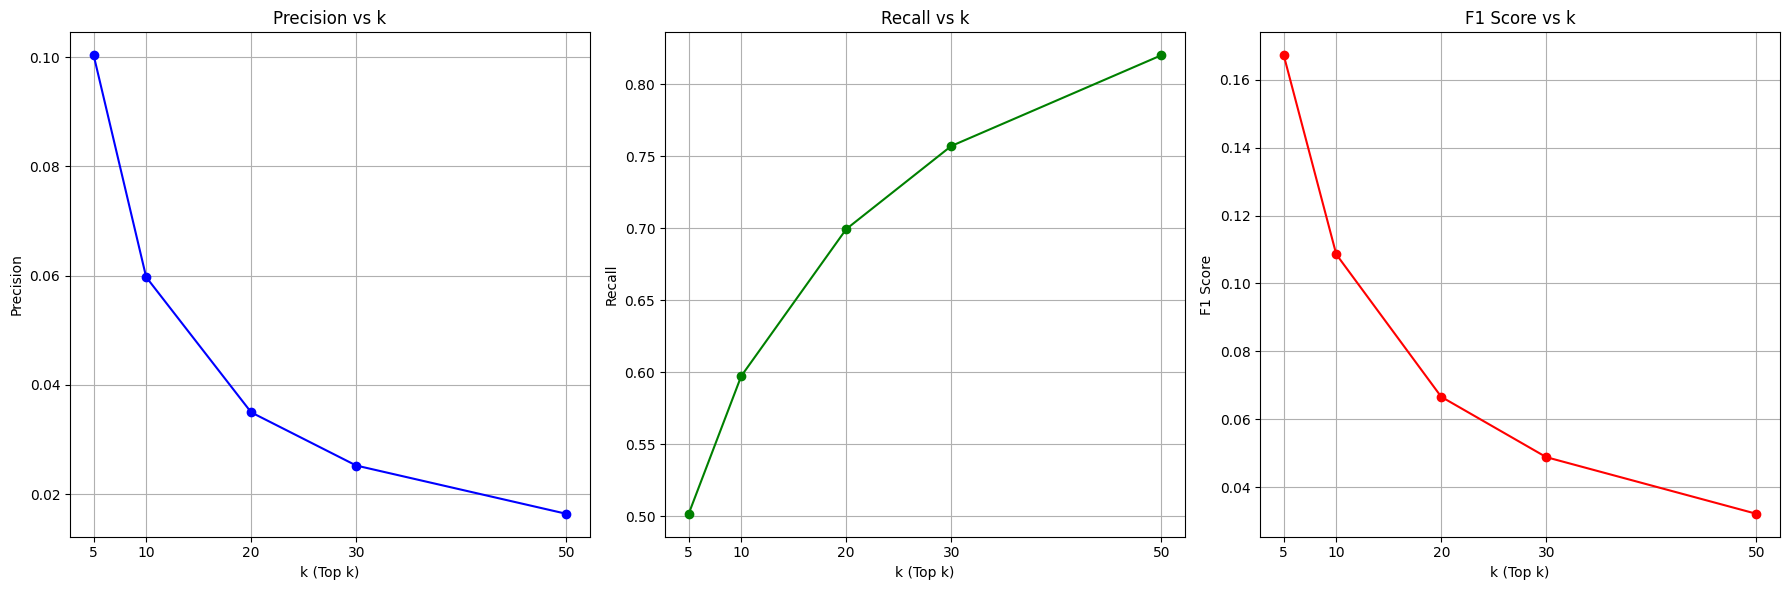

In [14]:
# Plot Precision, Recall, F1-Score for different k values
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Precision plot
axes[0].plot(list(precisions.keys()), list(precisions.values()), marker='o', label='Precision', color='b')
axes[0].set_title('Precision vs k')
axes[0].set_xlabel('k (Top k)')
axes[0].set_ylabel('Precision')
axes[0].set_xticks([5, 10, 20, 30, 50])
axes[0].grid(True)

# Recall plot
axes[1].plot(list(recalls.keys()), list(recalls.values()), marker='o', label='Recall', color='g')
axes[1].set_title('Recall vs k')
axes[1].set_xlabel('k (Top k)')
axes[1].set_ylabel('Recall')
axes[1].set_xticks([5, 10, 20, 30, 50])
axes[1].grid(True)

# F1-Score plot
axes[2].plot(list(f1_scores.keys()), list(f1_scores.values()), marker='o', label='F1 Score', color='r')
axes[2].set_title('F1 Score vs k')
axes[2].set_xlabel('k (Top k)')
axes[2].set_ylabel('F1 Score')
axes[2].set_xticks([5, 10, 20, 30, 50])
axes[2].grid(True)

plt.tight_layout()
plt.show()


In [85]:
# Testing the model
test_images = []

for filename in [f for f in os.listdir(image_splits_dir) if f.endswith('.test.json')]:
    image_file = os.path.join(image_splits_dir, filename)
    with open(image_file, 'r') as f:
        test_images += json.load(f)
print(f"Total test images: {len(test_images)}")

Total test images: 15538


Top 5 retrieved images: [('B004TJ2UR4', 5.6790771484375), ('B0051KY8IY', 6.027467250823975), ('B0051932YG', 6.087332725524902), ('B002ZLOVSO', 6.089166164398193), ('B007HZI9IQ', 6.104337692260742)]


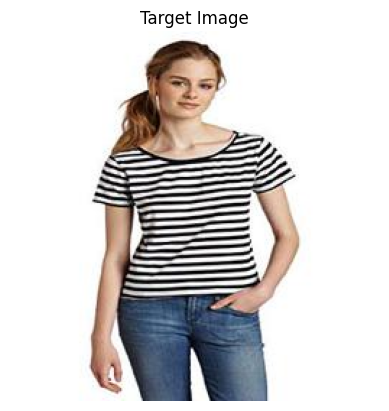

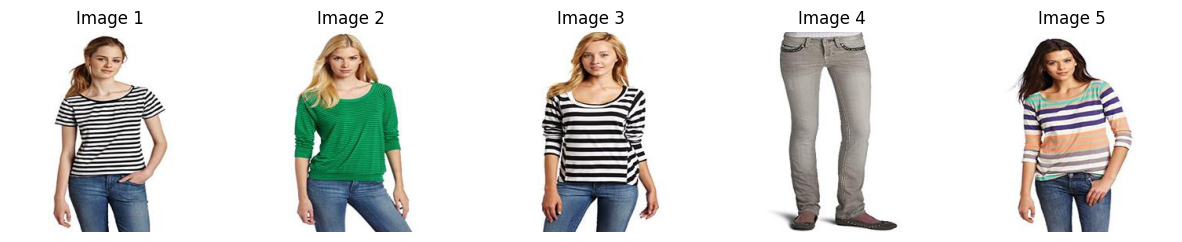

In [116]:
query_text = "is sleeveless and has a v-neck"
query_text_emb = get_text_embedding(query_text)

# pick random image from test set
query_image = random.choice(test_images)
query_image_emb = map_image_emb[query_image]

combined_query_emb = (query_image_emb + query_text_emb) / 2.0

image_distances = []
for image in map_image_emb:
    try:
        image_emb = map_image_emb[image]
        distance = euclidean_distance(combined_query_emb, image_emb)
        image_distances.append((image, distance.item()))
    except Exception as e:
        print(f"Error processing image {image}: {e}")

image_distances.sort(key=lambda x: x[1], reverse=False)
retrieved_images = image_distances[:5]
print(f"Top 5 retrieved images: {retrieved_images}")

# Display the target image
target_image_path = os.path.join(image_dir, query_image + ".jpg")
target_image = mpimg.imread(target_image_path)
plt.imshow(target_image)
plt.axis('off')
plt.title("Target Image")
plt.show()

# Display the top 5 retrieved images
plt.figure(figsize=(15, 10))
for i, (image_id, _) in enumerate(retrieved_images):
    image_path = os.path.join(image_dir, image_id + ".jpg")
    image = mpimg.imread(image_path)
    plt.subplot(1, 5, i + 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Image {i + 1}")
plt.show()